# **Transformers learn in-context by gradient descent**
This specific notebook can be used to reproduce the results shown in the paper when using the specific token construction i.e. concatinate input and targets i.e. $e_i = (x_i,y_i)$.

In [ ]:
#@title Imports external sources
import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import zipfile
import json
import requests
import matplotlib.pylab as pl
import numpy as np
import glob
import requests
import random as pyrandom
from concurrent import futures
from functools import partial
from scipy.ndimage import rotate
from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange
import time
from typing import Any, MutableMapping, NamedTuple, Tuple

!pip install --quiet --upgrade jax
!pip install --quiet --upgrade jaxlib
import jax
from jax import grad, jit, vmap
import jax.numpy as jnp

!pip install --quiet -U dm-haiku
!pip install --quiet -U optax
import haiku as hk
import math
!pip install --quiet -U ml_collections
from ml_collections import config_dict
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
colors = pl.colormaps['Dark2']
import matplotlib.pyplot as plt
import pandas as pd
import copy
import pickle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#@title Import internal sources (from github)
!git clone --quiet https://github.com/google-research/self-organising-systems.git /content/self-organising-systems > /dev/null 2>&1
%cd /content/self-organising-systems/transformers_learn_icl_by_gd
from src.transformer import Transformer
from src.data import create_reg_data_classic_token, create_weights
from src.config import config
from src.train import *

/content/self-organising-systems/transformers_learn_icl_by_gd


In the following you can play around with the experimental setup.
A couple of things to note:

1.   **"recurrent_Transformer"** chooses if we want to share the same weights across multiple self-attention layers.  

2. **num_seeds** > 1 will rerun and show results of the experiment with the same config but with different seeds. For quick execution set this to 1.

3. Note that when choosing softmax, we need to increase the num_heads to a minimum of 2 to get good performance and alignment with GD.

4. The experiments run much quicker when using a GPU or TPU.

In [ ]:
#@title Config
softmax = False #@param {type:"boolean"}
layernorm = False #@param {type:"boolean"}

recurrent_Transformer = False #@param {type:"boolean"}
num_layers = 5 #@param {type:"integer"}
num_heads = 1 #@param {type:"integer"}
num_seeds = 1 #@param {type:"integer"}

config.seed = 0
config.local_usage = True

####
config.deq = recurrent_Transformer
config.gd_deq = recurrent_Transformer
config.att_only_trans = True
####

config.pre_train_gd = True
config.train_gd_whitening = True
config.train_gd_lr = True
config.use_bias = False
config.include_query = False

config.distract_size = 0
config.training_steps = 5000 if config.deq else 50000
config.training_steps_gd = 1000 if config.gd_deq else 30000
config.use_softmax = softmax
config.first_layer_sm = False
config.use_non_lin_mix = False

config.widening_factor = 4

config.layer_norm = layernorm
config.out_proj = False
config.in_proj = False
config.adam = True
config.dataset_size = 10
config.input_size = 10
config.key_size = 11
config.num_layers = num_layers
config.num_heads = num_heads

config.grad_clip_value = 10 if num_layers > 2 else 0.001
config.grad_clip_value_gd = 10 if num_layers > 2 else 0.001
config.lr = 0.0005 if num_layers > 3 else 0.001
config.gd_lr = 0.0005 if num_layers > 3 else 0.001
config.wd = 0.0
config.init_scale = 0.002 / config.num_layers
config.bs = 2048
config.bs_gd_train = 512
config.dampening = 1.0
config.clip = 10 if num_layers > 3 else 0

config.dropout_rate = 0.0
# data_creator = vmap(create_reg_data,
#                     in_axes=(0, None, None, None, None, None),
#                     out_axes=0)

config.y_update = False
config.input_range = 1

config.pos_enc = False
config.pos_enc_size = 20
config.concat_pos_enc = False
config.analyse = True

config.cycle_data = 0 #0 means online learning
config.num_seeds = num_seeds
if config.num_layers == 1:
  assert config.deq == True
  assert config.gd_deq == True

if config.num_layers > 1:
  assert config.y_update == False

config.in_proj = False
config.emb_size = 11

In [ ]:
#@title Utils
pl.rcParams.update({'font.size': 12})
pl.rc('axes', labelsize=14)
pl.rcParams.update({
    "text.usetex": False,
})

import matplotlib.colors as mcolors
colors = pl.colormaps['Dark2']
def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb') #GFile.open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image."""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def display_learning(train, test=None, gt=None, inter=None, title="train",
                     title1="Trained TF", title2="Test",
                     title3='Gradient descent', title4='Interpolated',
                     y_label1 = 'L2 Norm', y_label2 = 'Cosine sim',
                     y_lim_l=0,  y_lim_u=1, single_seeds= False,
                     plot_title = None,
                     y_lim_u2= 1., y_lim_l2=0.,  x_label = 'Training steps',
                     second_axis=False, color_add=0, rw=10, num_iter_os=None,
                     allow_download=False, plot_num=1, two_plots=False,
                     loc_first = 'upper left', label_title="Loss",
                     loc_sec='upper left', yscale_log=False, line="-",
                     color_axis=True,
                     height=3.5, width = 4, ax1=None, ax2=None):

  """Update learning curve image."""

  train_list = train
  train = np.array(train)
  num_seeds_train = train.shape[0]
  train_std = np.std(train, axis=0)
  train = np.mean(train, axis=0)

  if test is not None:
    test_list = test
    test_std = np.std(test, axis=0)
    test = np.mean(test, axis=0)

  if gt is not None:
    gt_list = gt
    gt_std = np.std(gt, axis=0)
    gt = np.mean(gt, axis=0)

  if inter is not None:
    inter_list = inter
    inter_std = np.std(inter, axis=0)
    inter = np.mean(inter, axis=0)

  if plot_num == 1:
    fig, ax1 = pl.subplots()
    ax1.set_xlabel(x_label)
    fig.set_size_inches(width, height)


  if test is not None and not second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(test)))
    if len(test_list) > 1:
      if single_seeds:
        for s in test_list:
          ax1.plot(x_range, s, color=colors(0.1+color_add), alpha=0.2, label=title2,linewidth='2')
      else:
        ax1.fill_between(x_range, test-test_std, test+test_std ,alpha=0.2, facecolor=colors(0.1+color_add))
    ax1.plot(x_range, test, color=colors(0.1+color_add), label=title2,linewidth='3')
    #test_avg = moving_average(test, rw)
    #ax1.plot(x_range[:len(test_avg)], test_avg, color=colors(0.1+color_add), label=title2)

  if gt is not None:
    if not second_axis:
      x_range = np.arange(0, num_iter_os, int(num_iter_os/len(gt)))
      #ax1.plot(x_range[:len(gt[:-rw])], gt[:-rw], color=colors(0.2+color_add), alpha=0.3)
      #gt_avg = moving_average(gt, rw)
      ax1.plot(x_range, gt, color=colors(0.2+color_add), label=title3,linewidth='3')
      if len(gt_list) > 1:
        if single_seeds:
          for s in gt_list:
            ax1.plot(x_range, s, color=colors(0.2+color_add), alpha=0.2, linewidth='2', zorder=0)
        else:
          ax1.fill_between(x_range, gt-gt_std, gt+gt_std,alpha=0.2, facecolor=colors(0.2+color_add))
    else:
      x_range = np.arange(0, num_iter_os, int(num_iter_os/len(gt)))
      ax1.plot(x_range, gt, color=colors(0.6+color_add), label=title3,linewidth='3')
      if len(gt_list) > 1:
        if single_seeds:
          for s in gt_list:
            ax1.plot(x_range, s, color=colors(0.6+color_add), alpha=0.3, linewidth='2', zorder=0)
        else:
          ax1.fill_between(x_range, gt-gt_std, gt+gt_std ,alpha=0.2, facecolor=colors(0.6+color_add))

  if test is not None and second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(test)))
    ax1.plot(x_range, test, color=colors(0.5+color_add), label=title2,linewidth='3')
    #test_avg = moving_average(test, rw)
    #ax1.plot(x_range[:len(test_avg)],test_avg, color=colors(0.5+color_add))
    if len(test_list) > 1:
      if single_seeds:
        for s in test_list:
          ax1.plot(x_range, s, color=colors(0.5+color_add), linewidth='2', alpha=0.3, zorder=0)
      else:
        ax1.fill_between(x_range, test-test_std, test+test_std ,alpha=0.2, facecolor=colors(0.5+color_add))

  if inter is not None and not second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(inter)))
    ax1.plot(x_range, inter, color=colors(0.4+color_add), label=title4, linewidth='3', zorder=10)
    if len(inter_list) > 1:
      if single_seeds:
        for s in inter_list:
          ax1.plot(x_range, s, color=colors(0.4+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax1.fill_between(x_range, inter-inter_std, inter+inter_std ,alpha=0.2, facecolor=colors(0.4+color_add), zorder=1)
    #inter_avg = moving_average(inter, rw)
    #ax1.plot(x_range[:len(inter_avg)], inter_avg, color=colors(0.7+color_add), label=title4)


  if second_axis:
    if ax2 is None:
      ax2 = ax1.twinx()
    ax2.set_zorder(0)
    ax1.set_zorder(1)
    ax1.set_frame_on(False)
    #train_avg = moving_average(train, rw)
    #ax2.plot(train[:-rw], color=colors(0.1+color_add), alpha=0.3)
    ax2.plot(x_range, train, color=colors(0.4+color_add), label=title1, linewidth='3')
    ax2.plot(x_range, np.ones_like(train), "--", color="gray", linewidth='0.7')
    if len(train_list) > 1:
      if single_seeds:
        for s in train_list:
          print(x_range, s)
          ax1.plot(x_range, s, line, color=colors(0.4+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax2.fill_between(x_range, train-train_std, train+train_std ,alpha=0.2, facecolor=colors(0.4+color_add))

    if color_axis:
      ax2.yaxis.label.set_color(colors(0.4+color_add))
    else:
      legend2 = ax2.legend(loc='upper right', framealpha=0.99, facecolor='white')
      legend2.set_zorder(100)
    ax2.spines['top'].set_visible(False)
  else:
    #train_avg = moving_average(train, rw)
    if line != "-":
      ax1.scatter(x_range, train, s=[100 for _ in x_range],
                  marker="+", color=colors(0.3+color_add), alpha=1, label=title1, zorder=3, linewidths=3)
    else:
      ax1.plot(x_range, train, line, color=colors(0.3+color_add), label=title1, linewidth='3', zorder=11)
    #ax1.plot(x_range[:len(train_avg)], train_avg, line, color=colors(0.3+color_add), label=title1)
    if len(train_list) > 1:
      if single_seeds:
          for s in train_list:
            ax1.plot(x_range, s, line, color=colors(0.3+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax1.fill_between(x_range, train-train_std, train+train_std,
                       alpha=0.5, facecolor=colors(0.3+color_add))

    ax1.legend(loc='best', framealpha=1, facecolor='white')
    ax1.spines['right'].set_visible(False)
    legend = ax1.legend(loc='upper right', framealpha=0.99, facecolor='white')
    legend.set_zorder(100)

  legend1 = ax1.legend(loc=loc_first, framealpha=0.99, facecolor='white')
  legend1.set_zorder(100)
  if second_axis:
    ax2.set_ylabel(y_label2)
    ax1.set_ylabel(y_label1)
    ax1.set_ylim(y_lim_l, y_lim_u)
    legend1 = ax1.legend(loc=loc_sec, framealpha=0.99, facecolor='white')
    ax2.set_ylim(y_lim_l2, y_lim_u2)
    ax1.set_ylim(bottom=0)
  else:
    pl.ylabel(label_title)
    pl.ylim(y_lim_l, y_lim_u)
  ax1.spines['top'].set_visible(False)

  if plot_title is not None:
    pl.title(plot_title)

  if yscale_log:
    ax1.set_yscale("log")
  #pl.title(title)
  pl.tight_layout()

  if allow_download:
    if second_axis:
      pl.savefig("sim.pdf", format="pdf")
      %download_file sim.pdf
    else:
      pl.savefig("train.pdf", format="pdf")
      %download_file train.pdf
  else:
    img = grab_plot()
    display(Image(data=imencode(img, fmt='jpeg')), display_id=title)


In [ ]:
#@title Lists

loss_trans_list =  [[]  for _ in range(config.num_seeds)]
loss_trans_train_list =  [[]  for _ in range(config.num_seeds)]
losses_gd_list =  [[]  for _ in range(config.num_seeds)]
losses_gd_list_trained =  [[]  for _ in range(config.num_seeds)]
losses_int_list_trained =  [[]  for _ in range(config.num_seeds)]
cos_sim_list, cos_sim_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]
grad_norm_list, grad_norm_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]
p_norm_list, p_norm_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]

cos_sim_list, cos_sim_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]
grad_norm_list, grad_norm_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]
p_norm_list, p_norm_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]

ir_t_list = [[]  for _ in range(config.num_seeds)]
ws_t_list = [[]  for _ in range(config.num_seeds)]
ir_gd_list = [[]  for _ in range(config.num_seeds)]
ws_gd_list = [[]  for _ in range(config.num_seeds)]

ir_t_ood_list = [[]  for _ in range(config.num_seeds)]
ws_t_ood_list = [[]  for _ in range(config.num_seeds)]
ir_gd_ood_list = [[]  for _ in range(config.num_seeds)]
ws_gd_ood_list = [[]  for _ in range(config.num_seeds)]

ir_gd_trained_list = [[]  for _ in range(config.num_seeds)]
ws_gd_trained_list = [[]  for _ in range(config.num_seeds)]
ir_gd_ood_trained_list = [[]  for _ in range(config.num_seeds)]
ws_gd_ood_trained_list = [[]  for _ in range(config.num_seeds)]

ir_inter_list = [[]  for _ in range(config.num_seeds)]
ws_inter_list = [[]  for _ in range(config.num_seeds)]
ir_inter_ood_list = [[]  for _ in range(config.num_seeds)]
ws_inter_ood_list = [[]  for _ in range(config.num_seeds)]


losses_noisy_list = [[]  for _ in range(config.num_seeds)]
losses_gd_noisy_list = [[]  for _ in range(config.num_seeds)]
losses_gd_noisy_trained_list = [[]  for _ in range(config.num_seeds)]
losses_inter_noisy_list = [[]  for _ in range(config.num_seeds)]

In [ ]:
#@title Logic how to interpolate weights
def interpolate_weights(train_state, params_gd, deq=False):
  if (config.num_heads == 1 and
      config.sum_norm == False and config.deq == True and
      config.layer_norm == False and config.att_only_trans == True):

    cur_train_params = {k.replace('transformer', 'Transformer_gd'):v.copy() for
                    k,v in train_state.params.items()}

    inter_params = {k.replace('transformer', 'Transformer_gd'): {'w': jnp.zeros_like(v['w'])} for
                    k,v in train_state.params.items()}

    for k,v in cur_train_params.items():
      if "key" in k:
        key_gd  = params_gd[k]['w'].copy()
        key  = cur_train_params[k]['w'].copy()
      if "linear" in k:
        linear_gd = params_gd[k]['w'].copy()
        linear = cur_train_params[k]['w'].copy()
      if "query" in k:
        query_gd = params_gd[k]['w'].copy()
        query = cur_train_params[k]['w'].copy()
      if "value" in k:
        value_gd = params_gd[k]['w'].copy()
        value = cur_train_params[k]['w'].copy()

        query = jnp.matmul(query, key.T)
        #print(query)
        key = jnp.identity(query.shape[0])
        mean = np.mean([query[a, a] for a in range(query.shape[0]-1)])
        query = query/mean
        query_gd = jnp.matmul(query_gd, key.T)
        key_gd = jnp.identity(query.shape[0])
        query = (query + query_gd)/2

        linear = jnp.matmul(value, linear)
        #print(linear)
        value = jnp.identity(query.shape[0])
        linear = linear*mean
        linear_gd = jnp.matmul(value_gd, linear_gd)
        value_gd = jnp.identity(query.shape[0])
        linear = (linear + linear_gd)/2

        inter_params[k.replace('value', 'linear')]['w'] = linear
        inter_params[k.replace('value', 'value')]['w'] = value
        inter_params[k.replace('value', 'query')]['w'] = query
        inter_params[k.replace('value', 'key')]['w'] = key

    losses_int, _, _ = predict_test.apply(inter_params, eval_rng, eval_data, True)
  else:
    losses_int = None
    inter_params = None
  return losses_int, inter_params

In [ ]:
#@title Create datasets

"""Data utils.
  Provide functions to create regression datasets.
"""

from functools import partial
import jax
from jax import vmap
import jax.numpy as jnp
import numpy as np


@partial(jax.jit, static_argnums=(1, 2, 3))
def create_data_normal(rng, i_size, c_size, size_distract, input_range, w_scale):
  """Create a linear regression data set: X*w where x ~ N(0, 1), w ~ N(1,1)."""

  rng, new_rng, new_rng2, new_rng3, new_rng4 = jax.random.split(rng, 5)
  w = 1 + jax.random.normal(rng, shape=[i_size])*w_scale
  x = jax.random.normal(new_rng, shape=[c_size, i_size])*w_scale
  x_querry = jax.random.normal(new_rng2, shape=[1, i_size])*w_scale

  y_data = jnp.squeeze(x@w)

  y_target = x_querry@w
  y_target = y_target[..., None]


  seq = jnp.concatenate([x, y_data[..., None]], -1)
  target = jnp.concatenate([x_querry, y_target], -1)
  x_querry_init = -1*x_querry.dot(jnp.ones_like(x_querry).T*0.0)
  zero = jnp.concatenate([x_querry, x_querry_init], -1)
  seq = jnp.concatenate([seq, zero], 0)
  return jnp.squeeze(seq), jnp.squeeze(target), w



@partial(jax.jit, static_argnums=(1, 2, 3))
def create_data_normal_noisy(rng, i_size, c_size, size_distract, input_range, eps_sigma):
  """Create a linear regression data set: X*w where x ~ N(0, 1), w ~ N(1,1) eps ~ N(0, eps_sigma)."""

  rng, new_rng, new_rng2, new_rng3, new_rng4 = jax.random.split(rng, 5)
  w = 1 + jax.random.normal(rng, shape=[i_size])
  x = jax.random.normal(new_rng, shape=[c_size, i_size])
  x_querry = jax.random.normal(new_rng2, shape=[1, i_size])

  y_data = jnp.squeeze(x@w) + jax.random.normal(new_rng3, shape=[c_size,])*eps_sigma

  y_target = x_querry@w + jax.random.normal(new_rng4, shape=[1,])*eps_sigma
  y_target = y_target[..., None]


  seq = jnp.concatenate([x, y_data[..., None]], -1)
  target = jnp.concatenate([x_querry, y_target], -1)
  x_querry_init = -1*x_querry.dot(jnp.ones_like(x_querry).T*0.0)
  zero = jnp.concatenate([x_querry, x_querry_init], -1)
  seq = jnp.concatenate([seq, zero], 0)
  return jnp.squeeze(seq), jnp.squeeze(target), w


@partial(jax.jit, static_argnums=(1, 2, 3))
def create_data_sin(rng, i_size, c_size, size_distract, input_range, eps_sigma):
  """Create a linear regression data set: X*w where x ~ N(0, 1), w ~ N(0,1) eps ~ N(0, eps_sigma)."""

  rng, new_rng, new_rng2, new_rng3, new_rng4, new_rng5, new_rng6 = jax.random.split(rng, 7)
  w = jax.random.normal(rng, shape=[i_size])

  v = jnp.cos(jnp.arange(1,i_size+1) * jnp.pi / 5)
  a = jax.random.normal(new_rng, shape=[c_size])
  av = jnp.broadcast_to(a, shape=(i_size, c_size)).transpose() * v

  u = jnp.sin(jnp.arange(1,i_size+1) * jnp.pi / 5)
  b = jax.random.normal(new_rng2, shape=[c_size])
  bu = jnp.broadcast_to(b, shape=(i_size, c_size)).transpose() * u

  eps = jax.random.normal(new_rng3, shape=[c_size, i_size]) * eps_sigma
  x = av + bu + eps

  a_q = jax.random.normal(new_rng4, shape=[1])
  b_q = jax.random.normal(new_rng5, shape=[1])
  eps_q = jax.random.normal(new_rng6, shape=[1, i_size]) * eps_sigma
  av_q = jnp.broadcast_to(a_q, shape=(i_size, 1)).transpose() * v
  bu_q = jnp.broadcast_to(b_q, shape=(i_size, 1)).transpose() * u

  x_querry = av_q + bu_q + eps_q


  y_data = jnp.squeeze(x@w)

  y_target = x_querry@w
  y_target = y_target[..., None]


  seq = jnp.concatenate([x, y_data[..., None]], -1)
  target = jnp.concatenate([x_querry, y_target], -1)
  x_querry_init = -1*x_querry.dot(jnp.ones_like(x_querry).T*0.0)
  zero = jnp.concatenate([x_querry, x_querry_init], -1)
  seq = jnp.concatenate([seq, zero], 0)
  return jnp.squeeze(seq), jnp.squeeze(target), w


In [ ]:
#@title config
# config.bs = 5000
config.input_size = 10
config.dataset_size = 10
config.training_steps = 5000 # 5000

In [1]:
#@title Training - varying M and N
config.training_steps = 10000

designed_params_list = []


trained_params_list_m = []
# for M in [10,20,40,80]:
for M in [20, 50,100,500,1000]:
  trained_params_list = []
  for ds_size in [5,10,15,20]:
    config.dataset_size = ds_size
    config.bs = M

    # interpolate GD and trained TF
    inter = True if (config.deq and not config.use_softmax and config.num_heads == 1) else False

    data_creator = vmap(create_data_sin,
                        in_axes=(0, None, None, None, None, None),
                        out_axes=0)

    params_trained_trans = None
    eval_rng = jax.random.PRNGKey(5)
    for cur_seed in range(0, config.num_seeds):
      config.seed = cur_seed
      optimiser, train_state, _, rng = init()
      rng, data_rng = jax.random.split(rng, 2)
      if config.analyse: # 0.07
        lr_min, min_loss = .05, .1 #scan_lrs(eval_rng, lin_diag=False, bs=10000) # 0.5, .1
        if cur_seed == 0:
          print('Best lr found for ', config.num_layers ,' steps of gradient descent: ', lr_min/config.dataset_size, " with loss ", min_loss)

        params_gd = create_weights(config.input_size, 1, config.dataset_size, lr_min,
                                    jax.random.normal(data_rng, shape=[1, 1, config.input_size])*0 ,
                                  lin_diag=False, gd_deq=config.gd_deq,
                                  num_layers=config.num_layers,
                                  input_mlp_rnd=rng if (config.input_mlp or config.in_proj) else None,
                                  in_proj=config.in_proj)
        if config.num_layers > 1 or (config.in_proj and config.num_layers == 1):
          if cur_seed == 0:
            lr_min, min_loss = scan_lrs(eval_rng, lin_diag=True, bs=10000)

            params_init = create_weights(config.input_size, 1, config.dataset_size, lr_min,
                                      jax.random.normal(data_rng, shape=[1, 1, config.input_size])*0,
                                    lin_diag=True, gd_deq=config.gd_deq,
                                    num_layers=config.num_layers,
                                    input_mlp_rnd=eval_rng if (config.input_mlp or config.in_proj) else None,
                                   in_proj=config.in_proj)
            params_gd_trained, data_rng = pre_train_gd_hps(eval_rng, params_init)
        else:
            params_gd_trained = params_gd

      eval_data = data_creator(jax.random.split(eval_rng, num=10000),
                                  config.input_size,
                                  config.dataset_size,
                                  config.size_distract,
                                  config.input_range,
                                  config.weight_scale)
      if config.analyse:
        loss_gd, _, _ = predict_test.apply(params_gd, eval_rng, eval_data,True)
        loss_gd_trained, _, _ = predict_test.apply(params_gd_trained, eval_rng,
                                                    eval_data, True)

      original_data_rng = data_rng
      rng, data_rng = jax.random.split(data_rng, 2)
      train_data = data_creator(jax.random.split(rng, num=config.bs),
                                config.input_size,
                                config.dataset_size,
                                config.size_distract,
                                config.input_range,
                                config.weight_scale)
      for step in range(config.training_steps):
        if config.cycle_data > 0:
          if step % config.cycle_data == 0:
            data_rng = original_data_rng

        # rng, data_rng = jax.random.split(data_rng, 2)
        # train_data = data_creator(jax.random.split(rng, num=config.bs),
        #                           config.input_size,
        #                           config.dataset_size,
        #                           config.size_distract,
        #                           config.input_range,
        #                           config.weight_scale)
        train_state, metrics = update(train_state, train_data, optimiser)
        if step % 100 == 0:

          loss_trans, _, _ = predict_test.apply(train_state.params, eval_rng,
                                                eval_data, False)

          params_trained_trans = train_state.params

          loss_trans_list[cur_seed].append(loss_trans)
          loss_trans_train_list[cur_seed].append(metrics['train_loss'].item(),)
          if config.analyse:
            losses_gd_list[cur_seed].append(loss_gd)
            # losses_gd_list_trained[cur_seed].append(loss_gd_trained)

            # losses_int, inter_params = interpolate_weights(train_state, params_gd_trained)

            # losses_int_list_trained[cur_seed].append(losses_int)

            #rng, data_rng, eval_rng = jax.random.split(data_rng, 3)
            # Alignment Transformers and GD
            # cos_sim, w_norm, p_norm = analyse(eval_data, train_state, eval_rng,
            #                                   params_gd)
            # cos_sim_o, w_norm_o, p_norm_o = analyse(eval_data, train_state, eval_rng,
            #                                   params_gd_trained)

            if step > 0:
              display(("Current seed", cur_seed,
                      "Training step", step, "Gradient descent loss", loss_gd.item(),
                        "GD ++ loss", loss_gd_trained.item(),
                        "Trained TF loss", loss_trans.item()),
                        # "Interpolated model loss", losses_int.item() if inter else "-",),
                        # "Cosine sim TF vs GD", cos_sim.item(),
                        # "Cosine sim TF vs GD++", cos_sim_o.item() if config.num_layers > 1 else "-"),
                        display_id="Cur met")
            print("Training step", step,"Trained TF loss", loss_trans.item(), M, ds_size)


          else:
            print(step, loss_trans)

    # designed_params_list.append(copy.deepcopy(params_gd))
    trained_params_list.append(copy.deepcopy(train_state.params))
  trained_params_list_m.append(trained_params_list)

In [2]:
#@title Training varying M and Sigma


designed_params_list_m = []
config.training_steps = 5000

trained_params_list_m = []
M = 500
# for sigma in [0, 1/100, 1/10, 1, 5, 10]:
for sigma in [0, 1/10, 1, 5, 10]:

  trained_params_list = []
  designed_params_list = []
  # for ds_size in [5,10,15,20]:
  for ds_size in [20,10,15,20]:
    config.dataset_size = ds_size
    config.bs = M
    # config.weight_scale = sigma

    # interpolate GD and trained TF
    inter = True if (config.deq and not config.use_softmax and config.num_heads == 1) else False

    data_creator = vmap(create_data_normal_noisy,
                        in_axes=(0, None, None, None, None, None),
                        out_axes=0)

    params_trained_trans = None
    eval_rng = jax.random.PRNGKey(5)
    for cur_seed in range(0, config.num_seeds):
      config.seed = cur_seed
      optimiser, train_state, _, rng = init()
      rng, data_rng = jax.random.split(rng, 2)
      if config.analyse: # 0.07
        lr_min, min_loss = .5, .1 #scan_lrs(eval_rng, lin_diag=False, bs=10000) # 0.5, .1
        if cur_seed == 0:
          print('Best lr found for ', config.num_layers ,' steps of gradient descent: ', lr_min/config.dataset_size, " with loss ", min_loss)

        params_gd = create_weights(config.input_size, 1, config.dataset_size, lr_min,
                                    jax.random.normal(data_rng, shape=[1, 1, config.input_size])*0 ,
                                  lin_diag=False, gd_deq=config.gd_deq,
                                  num_layers=config.num_layers,
                                  input_mlp_rnd=rng if (config.input_mlp or config.in_proj) else None,
                                  in_proj=config.in_proj)
        # if config.num_layers > 1 or (config.in_proj and config.num_layers == 1):
        #   if cur_seed == 0:
        #     lr_min, min_loss = scan_lrs(eval_rng, lin_diag=True, bs=10000)

        #     params_init = create_weights(config.input_size, 1, config.dataset_size, lr_min,
        #                               jax.random.normal(data_rng, shape=[1, 1, config.input_size])*0,
        #                             lin_diag=True, gd_deq=config.gd_deq,
        #                             num_layers=config.num_layers,
        #                             input_mlp_rnd=eval_rng if (config.input_mlp or config.in_proj) else None,
        #                            in_proj=config.in_proj)
        #     params_gd_trained, data_rng = pre_train_gd_hps(eval_rng, params_init)
        # else:
        #     params_gd_trained = params_gd

      eval_data = data_creator(jax.random.split(eval_rng, num=10000),
                                  config.input_size,
                                  config.dataset_size,
                                  config.size_distract,
                                  config.input_range,
                                  sigma)
      if config.analyse:
        loss_gd, _, _ = predict_test.apply(params_gd, eval_rng, eval_data,True)
        # loss_gd_trained, _, _ = predict_test.apply(params_gd_trained, eval_rng,
        #                                             eval_data, True)

      original_data_rng = data_rng
      rng, data_rng = jax.random.split(data_rng, 2)
      train_data = data_creator(jax.random.split(rng, num=config.bs),
                                config.input_size,
                                config.dataset_size,
                                config.size_distract,
                                config.input_range,
                                sigma)
      for step in range(config.training_steps):
        if config.cycle_data > 0:
          if step % config.cycle_data == 0:
            data_rng = original_data_rng

        # rng, data_rng = jax.random.split(data_rng, 2)
        # train_data = data_creator(jax.random.split(rng, num=config.bs),
        #                           config.input_size,
        #                           config.dataset_size,
        #                           config.size_distract,
        #                           config.input_range,
        #                           config.weight_scale)
        train_state, metrics = update(train_state, train_data, optimiser)
        if step % 100 == 0:

          loss_trans, _, _ = predict_test.apply(train_state.params, eval_rng,
                                                eval_data, False)

          params_trained_trans = train_state.params

          loss_trans_list[cur_seed].append(loss_trans)
          loss_trans_train_list[cur_seed].append(metrics['train_loss'].item(),)
          if config.analyse:
            losses_gd_list[cur_seed].append(loss_gd)

            if step > 0:
              display(("Current seed", cur_seed,
                      "Training step", step, "Gradient descent loss", loss_gd.item(),
                        # "GD ++ loss", loss_gd_trained.item(),
                        "Trained TF loss", loss_trans.item()),
                        # "Interpolated model loss", losses_int.item() if inter else "-",),
                        # "Cosine sim TF vs GD", cos_sim.item(),
                        # "Cosine sim TF vs GD++", cos_sim_o.item() if config.num_layers > 1 else "-"),
                        display_id="Cur met")
            print("Training step", step,"Trained TF loss", loss_trans.item(), sigma, ds_size)



          else:
            print(step, loss_trans)

    designed_params_list.append(copy.deepcopy(params_gd))
    trained_params_list.append(copy.deepcopy(train_state.params))

  designed_params_list_m.append(designed_params_list)
  trained_params_list_m.append(trained_params_list)


In [ ]:
with open('losses_e.pickle', 'wb') as handle:
    pickle.dump(trained_params_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('losses_e.pickle', 'rb') as handle:
    cols = pickle.load(handle)

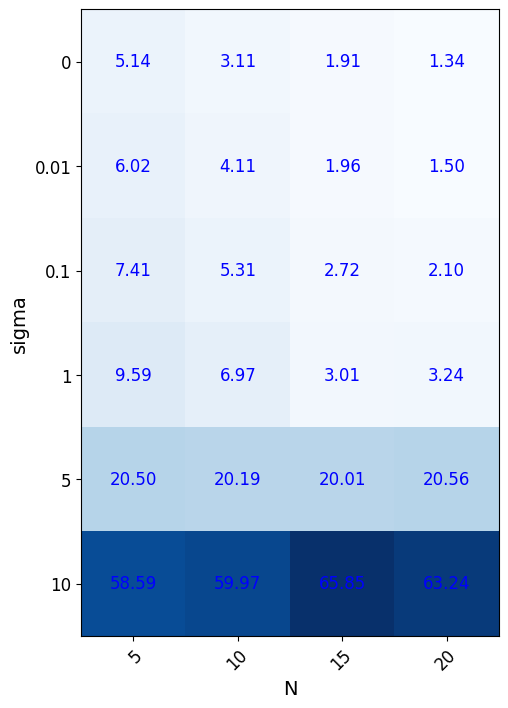

In [ ]:
N_range = np.arange(5, 21, 5)
sigmas = [0, 1/100, 1/10, 1, 5, 10]

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(cols, cmap='Blues')

x = N_range
y = sigmas
# # Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(x)), labels=x)
ax.set_yticks(np.arange(len(y)), labels=y)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(y)):
    for j in range(len(x)):
        text = ax.text(j, i, f"{cols[i][j]:.2f}",
                       ha="center", va="center", color="b")

# ax.set_title("Harvest of local farmers (in tons/year)")

fig.tight_layout()
plt.xlabel('N')
plt.ylabel('sigma')
plt.show()

In [ ]:
with open('losses_f.pickle', 'wb') as handle:
    pickle.dump(trained_params_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('losses_f.pickle', 'rb') as handle:
    cols = pickle.load(handle)

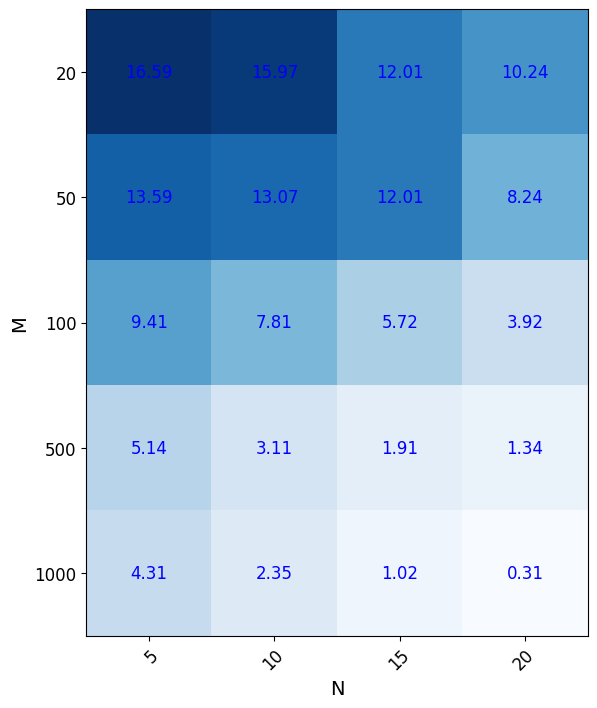

In [ ]:
N_range = np.arange(5, 21, 5)
M_range = [20, 50, 100, 500, 1000]

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(cols, cmap='Blues')

x = N_range
y = M_range
# # Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(x)), labels=x)
ax.set_yticks(np.arange(len(y)), labels=y)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(y)):
    for j in range(len(x)):
        text = ax.text(j, i, f"{cols[i][j]:.2f}",
                       ha="center", va="center", color="b")

# ax.set_title("Harvest of local farmers (in tons/year)")

fig.tight_layout()
plt.xlabel('N')
plt.ylabel('M')
plt.show()

## (d) check covariance of data

In [ ]:
@partial(jax.jit, static_argnums=(1, 2, 3))
def create_data_sin_analyze(rng, i_size, c_size, size_distract, input_range, eps_sigma):
  """Create a linear regression data set: X*w where x ~ N(0, 1), w ~ N(0,1) eps ~ N(0, eps_sigma)."""

  rng, new_rng, new_rng2, new_rng3, new_rng4, new_rng5, new_rng6 = jax.random.split(rng, 7)
  w = jax.random.normal(rng, shape=[i_size])

  v = jnp.cos(jnp.arange(1,i_size+1) * jnp.pi / 5)
  a = jax.random.normal(new_rng, shape=[c_size])
  av = jnp.broadcast_to(a, shape=(i_size, c_size)).transpose() * v

  u = jnp.sin(jnp.arange(1,i_size+1) * jnp.pi / 5)
  b = jax.random.normal(new_rng2, shape=[c_size])
  bu = jnp.broadcast_to(b, shape=(i_size, c_size)).transpose() * u

  eps = jax.random.normal(new_rng3, shape=[c_size, i_size]) * eps_sigma
  x = av + bu + eps
  return x

In [ ]:
data_creator = vmap(create_data_sin_analyze,
                    in_axes=(0, None, None, None, None, None),
                    out_axes=0)
eval_data = data_creator(jax.random.split(eval_rng, num=10000),
                              10,
                              1,
                              config.size_distract,
                              config.input_range,
                              1/100)

In [ ]:
x = jnp.squeeze(eval_data)
xnp = np.array(x)
data = np.cov(xnp.T)
df = pd.DataFrame(data=data)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9
0,1.006589,0.817641,0.316559,-0.305291,-0.810869,-1.006588,-0.817825,-0.316788,0.305433,0.810862
1,0.817641,1.015292,0.824963,0.319842,-0.307853,-0.817761,-1.015294,-0.825284,-0.319652,0.307735
2,0.316559,0.824963,1.018265,0.822659,0.312617,-0.316652,-0.824943,-1.018456,-0.822495,-0.312800
3,-0.305291,0.319842,0.822659,1.011464,0.813655,0.305260,-0.319707,-0.822812,-1.011288,-0.813835
4,-0.810869,-0.307853,0.312617,0.813655,1.004150,0.810914,0.308048,-0.312571,-0.813695,-1.004158
5,-1.006588,-0.817761,-0.316652,0.305260,0.810914,1.006787,0.817943,0.316878,-0.305401,-0.810906
6,-0.817825,-1.015294,-0.824943,-0.319707,0.308048,0.817943,1.015492,0.825262,0.319515,-0.307932
7,-0.316788,-0.825284,-1.018456,-0.822812,-0.312571,0.316878,0.825262,1.018846,0.822651,0.312757
8,0.305433,-0.319652,-0.822495,-1.011288,-0.813695,-0.305401,0.319515,0.822651,1.011311,0.813876
9,0.810862,0.307735,-0.312800,-0.813835,-1.004158,-0.810906,-0.307932,0.312757,0.813876,1.004366


In [ ]:
# normal data

data_creator = vmap(create_data_normal,
                    in_axes=(0, None, None, None, None, None),
                    out_axes=0)

# data_creator = vmap(create_reg_data,
#                     in_axes=(0, None, None, None, None, None),
#                     out_axes=0)


linear_designed_losses = []
linear_trained_losses = []
# for m in range(5, 50, 10):
#   loss_n_list = []
for i, n in enumerate(range(5, 21, 5)):
  l1 = designed_params_list[i]
  l2 = trained_params_list[i]
  eval_data = data_creator(jax.random.split(eval_rng, num=10000),
                              10,
                              n,
                              config.size_distract,
                              config.input_range,
                              config.weight_scale)


  loss_gd, _, _ = predict_test.apply(l1, eval_rng, eval_data,True)
  loss_trans, _, _ = predict_test.apply(l2, eval_rng,
                                            eval_data, False)

  # loss_gd_trained, _, _ = predict_test.apply(params_gd_trained, eval_rng,
                                              # eval_data, True)
  # loss_n_list.append(loss_gd)
  linear_designed_losses.append(loss_gd)
  linear_trained_losses.append(loss_trans)

In [ ]:
linear_designed_losses

[Array(8.491417, dtype=float32),
 Array(2.908009, dtype=float32),
 Array(1.5885612, dtype=float32),
 Array(1.0246572, dtype=float32)]

In [ ]:
linear_trained_losses[0].item()

3.265561819076538

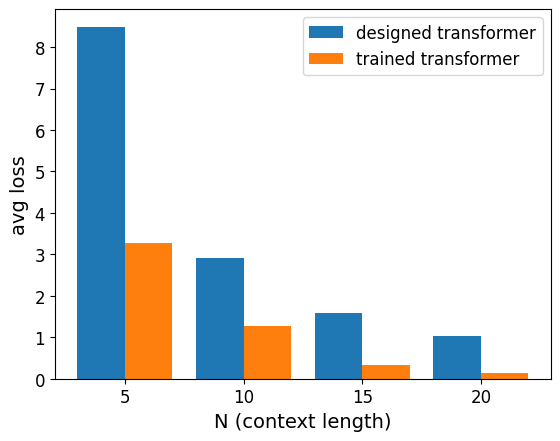

In [ ]:
import matplotlib.pyplot as plt
# X = ['Favorite','Roster','Search']
X = range(5, 21, 5)
low = [x.item() for x in linear_trained_losses]
high = [x.item() for x in linear_designed_losses]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, high, 0.4, label = 'designed transformer')
plt.bar(X_axis + 0.2, low, 0.4, label = 'trained transformer')

plt.xticks(X_axis, X)
plt.xlabel("N (context length)")
plt.ylabel("avg loss")
# plt.title("Quality Connections between Committed and Uncommitted")
plt.legend()
plt.show()

In [4]:
# evalulate transformers

data_creator = vmap(create_data_normal, # change task functional class
                    in_axes=(0, None, None, None, None, None),
                    out_axes=0)



linear_trained_losses_m = []
for i_m in range(4):
  # loss_n_list = []
  linear_trained_losses = []
  for i, n in enumerate(range(5, 21, 5)):
    # l1 = designed_params_list[i]
    l2 = trained_params_list_m[i_m][i]
    eval_data = data_creator(jax.random.split(eval_rng, num=10000),
                                10,
                                n,
                                config.size_distract,
                                config.input_range,
                                config.weight_scale)


    # loss_gd, _, _ = predict_test.apply(l1, eval_rng, eval_data,True)
    loss_trans, _, _ = predict_test.apply(l2, eval_rng,
                                              eval_data, False)

    # loss_gd_trained, _, _ = predict_test.apply(params_gd_trained, eval_rng,
                                                # eval_data, True)
    # loss_n_list.append(loss_gd)
    # linear_designed_losses.append(loss_gd)
    print(loss_trans, i_m, n)
    linear_trained_losses.append(loss_trans)
  linear_trained_losses_m.append(linear_trained_losses)

In [ ]:
with open('losses_m.pickle', 'wb') as handle:
    pickle.dump(linear_trained_losses_m, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('losses_m.pickle', 'rb') as handle:
    losses = pickle.load(handle)

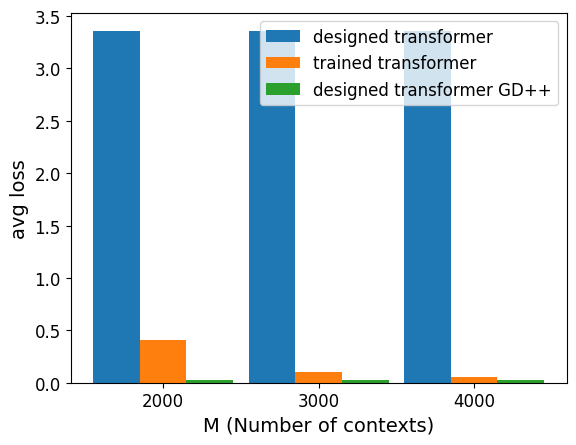

In [ ]:
# X = ['Favorite','Roster','Search']

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.3, gd, 0.3, label = 'designed transformer')
plt.bar(X_axis , t, 0.3, label = 'trained transformer')
plt.bar(X_axis + 0.3, gdp, 0.3, label = 'designed transformer GD++')


plt.xticks(X_axis, X)
plt.xlabel("M (Number of contexts)")
plt.ylabel("avg loss")
# plt.title("Quality Connections between Committed and Uncommitted")
plt.legend()
plt.show()

In [3]:
#@title Visualize loss and alignment measures (the printing layout is set to default and might be suboptimal)

# cosine_low = 0.0
# if config.num_layers == 1:
#   display_learning(loss_trans_list, test=[losses_gd_list[0]], y_lim_u=0.4, y_lim_l=0.2,
#                   rw=1, title="train.pdf", allow_download=False,
#                   single_seeds = True, label_title ="Loss",
#                   title2='GD', title1='Trained TF',
#                   title3='GD',  loc_first='upper right',
#                   num_iter_os=len(loss_trans_list[0])*100)

#   display_learning(cos_sim_list, grad_norm_list, p_norm_list,
#                   title1="Model cos",
#                   title2="Model diff", y_lim_u=2,
#                   title3="Preds diff", second_axis=True, color_add=0.2,
#                   y_lim_u2=1.19, loc_sec='center right', single_seeds = False,
#                   y_lim_l2=cosine_low, color_axis=False, width= 5, y_label2 = 'Cosine sim',
#                   rw=1, num_iter_os=len(grad_norm_list[0])*100, title="sim.pdf",
#                   allow_download=False)
# else:
#   display_learning(loss_trans_list, gt=losses_gd_list_trained,
#                    test=[losses_gd_list[0]], y_lim_u=0.3, y_lim_l=0.0,
#                    rw=1, title="train.pdf", allow_download=False,
#                    title2='GD', title1='Trained TF',
#                    title3='GD$^{++}$',loc_first='upper right', x_label = "Training steps",
#                    single_seeds = True, plot_title = None,
#                    num_iter_os=len(loss_trans_list[0])*100)

#   display_learning(cos_sim_list, grad_norm_list, p_norm_list, title1="Model cos",
#                   title2="Model diff", y_lim_u=1.8,
#                   title3="Preds diff", second_axis=True, color_add=0.2,
#                   y_lim_u2=1.09999999, color_axis=False,  width= 4, x_label = "Training steps",
#                   plot_title="GD vs trained TF",
#                   y_lim_l2=0.5, loc_sec = 'center right', y_label1 = 'L2 Norm', y_label2 = 'Cosine sim',
#                   rw=1, num_iter_os=len(loss_trans_list[0])*100, title="sim.pdf",
#                   allow_download=False, plot_num=1)

#   display_learning(cos_sim_list_o, grad_norm_list_o, p_norm_list_o, title1="Model cos",
#                   title2="Model diff", y_lim_u=1.8, x_label = "Training steps", plot_title = "GD$^{++}$ vs trained TF" ,
#                   title3="Preds diff", second_axis=True, color_add=0.2,
#                   y_lim_u2=1.0599999, color_axis=False, width= 4, y_label1 = 'L2 Norm', y_label2 = 'Cosine sim',
#                   y_lim_l2=0.5, loc_sec = 'center right',
#                   rw=1, num_iter_os=len(loss_trans_list[0])*100, title="sim2.pdf",
#                   allow_download=False)

In [ ]:
#@title Visualize iteratively applying a single layer Transformer layer
if config.gd_deq and config.num_heads == 1 and config.num_layers == 1:
  scale = 0.75

  train_state_final = train_state
  losses_gd, losses_tr, x_range = [], [], []

  orig_damp = config.dampening
  config.dampening = scale
  orig_num_layers = config.num_layers
  config.num_layers = 50

  config.y_update = True
  params_gd = create_weights(config.input_size, 1, config.dataset_size, lr_min*scale,
                                jax.random.normal(data_rng, shape=[1, 1, config.input_size])*0,
                              lin_diag=False,
                              gd_deq=config.gd_deq, num_layers=config.num_layers)
  x_range = np.arange(1, config.num_layers)

  _, int_params = interpolate_weights(train_state, params_gd)

  _, _, _, rng = init()
  _, _, losses_gd = predict_test.apply(params_gd, eval_rng, eval_data, True)
  _, _, losses_gd_train = predict_test.apply(params_gd_trained, eval_rng, eval_data, True)
  _, _, losses_tr = predict_test.apply(train_state.params, eval_rng, eval_data, False)
  _, _, losses_int = predict_test.apply(int_params, eval_rng, eval_data, True)
  config.num_layers = orig_num_layers
  config.orig_damp = orig_damp
  config.y_update = False
  train_state = train_state_final

if config.gd_deq and config.deq and config.num_heads == 1:
  if orig_num_layers > 1:
      display_learning([losses_tr], gt=[losses_gd_train], test=[losses_gd],
                      y_lim_u=10, y_lim_l=0.0,
                    rw=1, title="extra_gd_steps.pdf", allow_download=False,
                    title3='GD$^{++}$',
                    title2='GD', title1='Trained TF',
                    line="*", height = 2.5, loc_first='lower right',
                    x_label = 'Gradient steps / TF  steps',
                    num_iter_os=len(losses_tr))
  else:
      each = 3
      display_learning([losses_tr[0::each]], test=[losses_gd[0::each]], y_lim_u=0.27, y_lim_l=0.00,
                  rw=1, title="extra_gd_steps.pdf", allow_download=False,
                  #plot_title="Dampening $\lambda =$" +str(scale),
                  title3='GD$^{++}$' if config.pre_train_gd else 'GD',
                  title2='Gradient descent', title1='Trained Transformer',
                  line="+", height = 2.5, loc_first='upper right',
                  x_label = 'GD Steps / Transformer Layers',
                  num_iter_os=len(losses_tr[0::each])*each)


In [ ]:
#@title Visualize Transformer performance on larger inputs (comment out for other OOD)

#@title Config
Test_on_larger_inputs = True #@param {type:"boolean"}
Test_on_larger_targets = False #@param {type:"boolean"}
same_distribution = True #@param {type:"boolean"}

assert Test_on_larger_inputs or Test_on_larger_targets

log = True
every = 5
l_bound, u_bound = 0.06, 10
leg_loc = 'upper left'

if Test_on_larger_inputs:

  if same_distribution:
    title = r'Test on larger inputs'

    x_axis = r'$\alpha$   where x $\sim$ U($-\alpha, \alpha$)'
    download = 'Input scale'
    data = [ir_gd_list, ir_gd_trained_list, ir_t_list, ir_inter_list, np.arange(0.5, 2+0.03, 0.03)]
    training_x = np.ones([100])
    step = np.max(np.array(data[:1]))/100.
    training_y = np.arange(0, np.max(np.array(data[:1])) - step, step)
  else:

    leg_loc = 'upper left'
    x_axis = r'$\alpha$   where $\alpha x$'
    l_bound, u_bound = 0.008, 10
    every = 5
    data = [ir_gd_ood_list, ir_gd_ood_trained_list, ir_t_ood_list, ir_inter_ood_list, np.arange(0.5, 5+0.05, 0.05)]
    training_x = np.ones([100])
    step = np.max(np.array(data[:1]))/100.
    training_y = np.arange(0, np.max(np.array(data[:1])) - step, step)

if Test_on_larger_targets:
  title = r'Test on larger targets'

  if same_distribution:
    x_axis = r'$\alpha W$   where W $\sim$ N(0, I)'
    download = 'Weight scale'
    leg_loc = 'lower right'
    data = [ws_gd_list, ws_gd_trained_list, ws_t_list, ws_inter_list, np.arange(0.5, 5+0.1, 0.1)]
    training_x = np.ones([100])
    step = np.max(np.array(data[:1]))/100.
    training_y = np.arange(0, np.max(np.array(data[:1])) - step, step)

  else:

    x_axis = r'$\alpha W$   where W $\sim$ N(0, I)'
    download = 'Weight scale ood'
    data = [ws_gd_ood_list, ws_gd_ood_trained_list, ws_t_ood_list, ws_inter_ood_list, np.arange(0.5, 5+0.1, 0.1)]
    training_x = np.ones([100])
    step = np.max(np.array(data[:1]))/100.
    training_y = np.arange(0, np.max(np.array(data[:1])) - step, step)


"""
title = r'Test on noisy data'
every = 1
log = False
l_bound, u_bound = 0.2, 0.5
x_axis = 'Number of noisy data samples'
data = [losses_gd_noisy_list, losses_gd_noisy_trained_list, losses_noisy_list, losses_inter_noisy_list, np.arange(0, config.dataset_size, 2)]
training_x = np.zeros([100])
step = np.max(np.array(data[:1]))/100.
training_y = np.arange(np.min(np.array(data[:1])), np.max(np.array(data[:1])) - step, step)

"""

pl.rcParams.update({'font.size': 12})

fig, ax1 = pl.subplots()
fig.set_size_inches(4, 3.5)
pl.xlabel(x_axis)
pl.ylabel('Loss')
if log:
  pl.yscale('log')

#print(training_x, training_y)
pl.plot(training_x[:len(training_y)], training_y, "--", color="gray", linewidth='0.7',zorder=0)

stretch = data[-1][0::every]
gd_list = np.array(data[0])
num_seeds = gd_list.shape[0]

ir_gd_std = np.std(gd_list, axis=0)[0][0::every]
ir_gd = np.mean(gd_list, axis=0)[0][0::every]

ir_gd_trained_std = np.std(data[1], axis=0)[0][0::every]
ir_gd_trained = np.mean(data[1], axis=0)[0][0::every]

ir_t_std = np.std(data[2], axis=0)[0][0::every]
ir_t = np.mean(data[2], axis=0)[0][0::every]

ax1.scatter(stretch, ir_gd, s=[150 for _ in stretch], marker="v", color=colors(0.1),
         label="GD",linewidth=3, zorder=2)
ax1.plot(stretch, ir_gd, color=colors(0.1)
         ,linewidth='2', zorder=2)

#if num_seeds > 1:
#  ax1.fill_between(stretch, ir_gd-ir_gd_std*1, ir_gd+ir_gd_std*1, alpha=0.2, facecolor=colors(0.1), zorder=1)

if config.num_layers > 1:
  ax1.scatter(stretch, ir_gd_trained, s=[150 for _ in stretch], marker="x", color=colors(0.2),
          label="GD$^{++}$", zorder=4, linewidths=3)

  ax1.plot(stretch, ir_gd_trained, color=colors(0.2), linewidth=2, zorder=4)
  #if num_seeds > 1:
  #  ax1.fill_between(stretch, ir_gd_trained-ir_gd_trained_std*1, ir_gd_trained+ir_gd_trained_std*1, alpha=0.2, facecolor=colors(0.2))

if inter:
  ir_inter_std = np.std(data[3], axis=0)[0][0::every]
  ir_inter = np.mean(data[3], axis=0)[0][0::every]
  ax1.scatter(stretch, ir_inter, s=[10 for _ in stretch], marker="o", color=colors(0.4), label="Interpolated", linewidths=5, zorder=7)
  ax1.plot(stretch, ir_inter, color=colors(0.4), linewidth=2, zorder=7)
  #ax1.plot(stretch, ir_inter, "-", color=colors(0.4))
  #if num_seeds > 1:
  #  ax1.fill_between(stretch, ir_inter-ir_inter_std*1, ir_inter+ir_inter_std*1, alpha=0.2, facecolor=colors(0.4), zorder=1)

ax1.scatter(stretch, ir_t, s=[230 for _ in stretch], marker="+", color=colors(0.3), alpha=1, label="Trained TF", zorder=5, linewidths=3)
#ax1.plot(stretch, ir_t, "-", color=colors(0.3))
#if num_seeds > 1:
#    ax1.fill_between(stretch, ir_t-ir_t_std*1, ir_t+ir_t_std*1, alpha=0.2, facecolor=colors(0.3), zorder=3)
ax1.plot(stretch, ir_t, color=colors(0.3), linewidth=2, zorder=5)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([0.1], minor= [0.1])
pl.title(title)

legend1 = ax1.legend(loc=leg_loc,
                     framealpha=0.85, facecolor='white')
if 'ood' in download:
  pl.tight_layout()
  #pl.savefig("ood.pdf", format="pdf")
  #%download_file ood.pdf
else:
  pl.tight_layout()
  #pl.savefig("normal.pdf", format="pdf")
  #%download_file normal.pdf
pl.show()

In [ ]:
#@title Visualize attention heads
pl.rcParams.update({'font.size': 12})
pl.rc('axes', labelsize=14)
pl.rcParams.update({
    "text.usetex": False,
})


attn = predict_attn.apply(train_state.params, eval_rng,
                                            eval_data[0], False)
import matplotlib.colors as mcolors
colors = pl.cm.get_cmap('Dark2')

for n in range(config.num_layers):
  for head in range(attn[n].shape[1]):
    print("Layer ", n, "Head ", head)
    fig, (ax1, ax2) = pl.subplots(figsize=(8, 3), ncols=2)

    ax1.set_yticks(ticks=range(0, config.key_size-1))
    ax1.set_yticklabels(range(1, config.key_size))
    ax1.set_xticks(ticks=range(0, config.key_size+1))
    ax1.set_xticklabels(range(1, config.key_size+2))

    ax2.set_yticks(ticks=range(0, config.key_size-1))
    ax2.set_yticklabels(range(1, config.key_size))
    ax2.set_xticks(ticks=range(0, config.key_size+1))
    ax2.set_xticklabels(range(1, config.key_size+2))

    ax1.set_xlabel("Key")
    ax1.set_title("Single task act. of $K^TQ$")
    ax1.set_ylabel("Query")
    ax2.set_xlabel("Key")
    ax2.set_title("Task avg act. of $K^TQ$")
    single = jnp.squeeze(attn[n][0, head, :, :])
    mean = jnp.mean(attn[n][:, head, :, :], axis=0)
    vmin = jnp.max(jnp.abs(single))
    vmin2 = jnp.max(jnp.abs(mean))
    vmin = np.max([vmin, vmin2])
    pos = ax1.imshow(single, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax1, shrink=1)
    pos = ax2.imshow(mean, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax2, shrink=1)
    pl.show()

In [ ]:
#@title Visualize attention heads for single tasks

for i in range(5):
  fig, ax1 = pl.subplots(figsize=(4, 3))
  ax1.set_yticks(ticks=range(0, config.key_size-1))
  ax1.set_yticklabels(range(1, config.key_size))
  ax1.set_xticks(ticks=range(0, config.key_size+1))
  ax1.set_xticklabels(range(1, config.key_size+2))

  ax1.set_title("Task " + str(i+1) + " activation of $K^TQ$")
  single = jnp.squeeze(attn[0][i, 0, :, :])
  vmin = jnp.max(jnp.abs(single))
  pos = ax1.imshow(single, cmap='RdBu', vmin=-vmin, vmax=vmin)
  fig.colorbar(pos, ax=ax1, shrink=1)
  pl.show()

In [ ]:
#@title Visualize weights of Transformer

num_dim = config.key_size
for n in range(config.num_layers):
  for head in range(config.num_heads):
    KQ = jnp.identity(config.dataset_size + 1)
    LV = jnp.identity(config.dataset_size + 1)
    #print("Layer ", n, "Head ", head)
    fig, (ax1, ax2) = pl.subplots(figsize=(9, 3), ncols=2)
    ax1.set_yticks(ticks=range(0, config.key_size))
    ax1.set_yticklabels(range(1, config.key_size+1))
    ax1.set_xticks(ticks=range(0, config.key_size))
    ax1.set_xticklabels(range(1, config.key_size+1))

    ax2.set_yticks(ticks=range(0, config.key_size))
    ax2.set_yticklabels(range(1, config.key_size+1))
    ax2.set_xticks(ticks=range(0, config.key_size))
    ax2.set_xticklabels(range(1, config.key_size+1))

    for k,v in train_state.params.items():
      if config.deq == True or (str(n) in k and config.deq == False):
        #print(k, head, v['w'].shape, )
        if "key" in k:
          KQ = jnp.matmul(KQ, v['w'][:, head*num_dim: (head+1)*num_dim])
        elif "query" in k:
          KQ = jnp.matmul(KQ, v['w'][:, head*num_dim: (head+1)*num_dim].T)
        elif "value" in k:
          LV = jnp.matmul(v['w'][:, head*num_dim: (head+1)*num_dim], LV)
        elif "linear" in k:
          LV = jnp.matmul(v['w'][head*num_dim: (head+1)*num_dim, :], LV)

    if head == 0:
      first = KQ*LV[-1, -1]
    if head == 1:
      second = KQ*LV[-1, -1]

    vmin = jnp.max(jnp.abs(KQ))
    vmin2 = jnp.max(jnp.abs(LV))
    vmin = np.max([vmin, vmin2])
    ax1.set_title("Weights of $W^T_KW_V$")
    pos = ax1.imshow(KQ, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax1, shrink=1)
    ax2.set_title("Weight of $PW_V$")

    pos = ax2.imshow(LV, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax2, shrink=1)
    pl.show()

In [ ]:
#@title Visualize weight sum and products of Transformer, mostly for softmax correction visualization

if config.num_layers == 1:
  if config.num_heads > 1:
    vmin = jnp.max(jnp.abs(first + second))
    ax1.set_title("$W_{H1} + W_{H2}$")
    fig, (ax1) = pl.subplots(figsize=(4, 3), ncols=1)
    pos = ax1.imshow(first + second,cmap='RdBu', vmin=-vmin, vmax=vmin,)
    fig.colorbar(pos, ax=ax1, shrink=1)
    pl.show()
  else:
    fig, (ax1) = pl.subplots(figsize=(4, 3), ncols=1)
    ax1.set_title("$W_{PV}(-1, -1)*W_K^T W_Q$")
    pos = ax1.imshow(KQ*LV[-1, -1],cmap='RdBu', vmin=-vmin, vmax=vmin,)
    fig.colorbar(pos, ax=ax1, shrink=1)
    pl.show()


In [ ]:
#@title Gradient descent on linear regression
number_of_datapoints = 45 #@param {type:"integer"}
seed = 0 #@param {type:"integer"}

learning_rate = 1 #@param {type:"number"}
num_iterations = 100 #@param {type:"integer"}
input_size = 12 #@param {type:"number"}
output_size = 8 #@param {type:"number"}
num_data_sets = 2 #@param {type:"number"}

@partial(jax.jit, static_argnums=(1,2,3,4))
def create_lin_reg_data(rng: jnp.ndarray, i_size, o_size, c_size, input_scale) -> dict:
  """Create a linear regression data set.
     Function to learn is W*x where x ~ N(0,1) and W ~ N(0,1)"""
  rng, new_rng, new_rng_2   = jax.random.split(rng, 3)
  w = jax.random.normal(rng, shape=[o_size, i_size])
  x_train = jax.random.uniform(new_rng, shape=[c_size, i_size]) *2 - 1
  x_test = jax.random.uniform(new_rng_2, shape=[1, i_size]) *2 - 1
  y_train = w@x_train.T
  y_test = w@x_test.T
  return (x_train, y_train.T, x_test, y_test.T, w)

data_creator = vmap(create_lin_reg_data, in_axes=(0, None, None, None, None), out_axes=0)

def l2_norm(tree):
  """Compute the l2 norm of a pytree of arrays. Useful for weight decay."""
  leaves, _ = tree_flatten(tree)
  return 0.5*jnp.sqrt(sum(jnp.vdot(x, x) for x in leaves))

def forward(W, X, Y, X_test, Y_test, lr=1., wd=0.0):
  """Linear regresssion."""
  def compute_test_loss(W):
    P_test = jnp.einsum("...oj,...ij->...io", W, X_test)
    return 0.5*jnp.mean((Y_test-P_test)**2)

  def update_step(carry, i):
    (W, X, Y, lr, wd) = carry
    P = jnp.einsum("...oj,...ij->...io", W, X)
    #print(W, X, P)
    delta_W = -lr*1/X.shape[1]*(jnp.einsum("...ij,...ik->...jk", P-Y, X) - wd*W)
    return (W + delta_W, X, Y, lr, wd), (0.5*jnp.mean((Y-P)**2), compute_test_loss(W))
  (W, _, _, _, _), losses =  jax.lax.scan(update_step, (W, X, Y, lr, wd), xs=None, length=num_iterations)
  return W, losses

def lin_reg(params, data, lr=1.) -> jnp.ndarray:
  """Computes the MSE loss between targets and predictions."""
  X, Y = data[0], data[1]
  X_test, Y_test = data[2], data[3]
  W, losses = forward(params, X, Y, X_test, Y_test, lr)
  train_p = jnp.einsum("...oj,...ij->...io", W, X)

  test_p = jnp.einsum("...oj,...ij->...io", W, X_test)
  assert Y.shape == train_p.shape
  assert Y_test.shape == test_p.shape
  return (losses, jnp.mean((Y-train_p)**2), jnp.mean((Y_test-test_p)**2),
          jnp.sqrt(jnp.sum((W-data[4])**2)),
          train_p, test_p, W)

rng = jax.random.PRNGKey(seed)
rng, train_rng = jax.random.split(rng, 2)
data = data_creator(jax.random.split(rng, num=num_data_sets),
                    input_size, output_size, number_of_datapoints, 1)
W_init = np.repeat(jax.random.normal(train_rng,
                                     shape=[1, output_size, input_size]),
                   num_data_sets, axis=0)
lr_results = lin_reg(W_init, data, lr=learning_rate)
losses_test = lr_results[0][1]
config.key_size = input_size + output_size

old_iter = config.num_layers
config.num_layers = num_iterations

In [ ]:
#@title Running the constructed Transformer forward i.e. emulating gradient descent (Note that afterwards the train_state will be overwritten and you have to start the notebook again)

params_new = create_weights(input_size, output_size,
                            number_of_datapoints, learning_rate, W_init,
                            gd_deq=True)
#create w_token and context
query = jnp.concatenate([data[2], jnp.zeros_like(data[3])], axis=2)
context = jnp.concatenate([data[0], data[1]], axis=2)
all_data = jnp.concatenate([context, query], axis=1)

losses_trans_test, losses_trans_train = [], []
grads_trans = []
ws_trans = []

# Init query token with init prediction as y data
# (3, 1, 5) (3, 1, 10) (3, 5, 10)
inits = jnp.einsum("nkj,nij->nki", all_data[:, -1:, :-output_size], W_init)

all_data = all_data.at[:, -1:, -output_size:].set((-1)*inits)

test_prediction = []
#replace by scan
_, _, _, rng = init()
preds = predict.apply(params_new, rng, all_data, True)
preds_stack = predict_stack.apply(params_new, rng, all_data, True)
print("Prediction of GD: ", lr_results[-2][0])
print("Prediction of trained TF: ", preds[:, -1:, -output_size:][0]*(-1))
print("Differences in final predictions: ", np.linalg.norm(lr_results[-2] - preds[:, -1:, -output_size:]*(-1)))

config.num_layers = old_iter